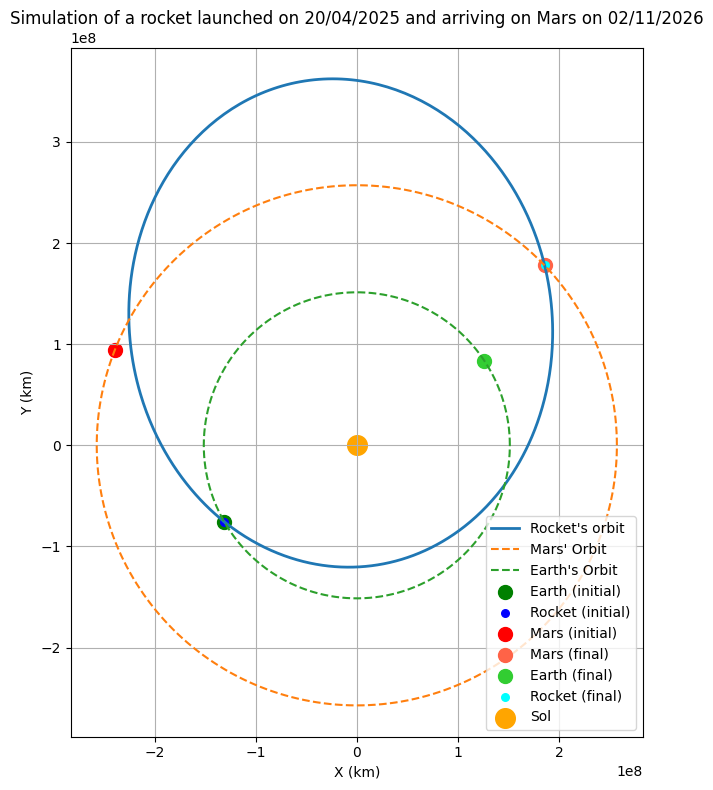

Marte ha dado 0.8165938864628821 órbitas.
El cohete ha dado 0.7467324830468085 órbitas.
La Tierra ha dado 1.536986301369863 órbitas.


{'Velocidad inicial óptima (km/s)': array([-27.0901834 ,  21.72009791,   0.02859795]),
 'Tiempo de vuelo (días)': 561,
 'Distancia final cohete-Marte (km)': np.float64(3600.768201681316),
 'Excentricidad': np.float64(0.504191436605516),
 'Semieje mayor (km)': np.float64(241949654.25475168)}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Constantes
GM_sun = 1.32712440018e11  # km^3/s^2
t_days = 561
t_seconds = t_days * 24 * 3600

# Posiciones y velocidades iniciales (20 abril 2025)
r0 = np.array([-1.3112578338e8, -7.5507634192e7, 3.0425664795e4])
v_earth = np.array([-1.4330580015e1, 2.5964645891e1, 7.9941675023e-4])
r_M = np.array([-2.3903020186e8, 9.4520480368e7, 7.6662920456e6])
v_Marte = np.array([-8.3495579277e0, -2.032012309e1, -2.209098865e-1])


# Magnitud orbital de Tierra para referencia (asumido circular)
r_T_mag = np.linalg.norm(r0)
omega_T = np.sqrt(GM_sun / r_T_mag**3)
theta_T0 = np.arctan2(r0[1], r0[0])
theta_T1 = (theta_T0 + omega_T * t_seconds) % (2 * np.pi)
r_T_target = r_T_mag * np.array([np.cos(theta_T1), np.sin(theta_T1), 0])


# Posiciones y velocidades iniciales (20 abril 2025)
r0 = np.array([-1.3112578338e8, -7.5507634192e7, 3.0425664795e4])
v_earth = np.array([-1.4330580015e1, 2.5964645891e1, 7.9941675023e-4])
r_M = np.array([-2.3903020186e8, 9.4520480368e7, 7.6662920456e6])

# Magnitud orbital de Marte para referencia (asumido circular)
r_M_mag = np.linalg.norm(r_M)
omega_M = np.sqrt(GM_sun / r_M_mag**3)
theta_M0 = np.arctan2(r_M[1], r_M[0])
theta_M1 = (theta_M0 + omega_M * t_seconds) % (2 * np.pi)
r_M_target = r_M_mag * np.array([np.cos(theta_M1), np.sin(theta_M1), 0])

# Función de costo: distancia cohete-Marte al cabo de 371 días
def cost_function(v0_flat):
    v0 = np.array(v0_flat)
    if np.linalg.norm(v0) > 50:
        return 1e10
    h = np.cross(r0, v0)
    energy = 0.5 * np.linalg.norm(v0)**2 - GM_sun / np.linalg.norm(r0)
    a = -GM_sun / (2 * energy)
    e_vec = (np.cross(v0, h) / GM_sun) - (r0 / np.linalg.norm(r0))
    e = np.linalg.norm(e_vec)
    if e >= 1 or a <= 0:
        return 1e10
    e_hat = e_vec / e
    h_hat = h / np.linalg.norm(h)
    p_hat = np.cross(h_hat, e_hat)
    cos_nu0 = np.dot(e_vec, r0) / (e * np.linalg.norm(r0))
    cos_nu0 = np.clip(cos_nu0, -1, 1)
    nu0 = np.arccos(cos_nu0)
    if np.dot(r0, v0) < 0: nu0 = 2 * np.pi - nu0
    E0 = 2 * np.arctan(np.tan(nu0 / 2) / np.sqrt((1 + e) / (1 - e)))
    M0 = E0 - e * np.sin(E0)
    n = np.sqrt(GM_sun / a**3)
    M1 = M0 + n * t_seconds
    E1 = M1
    for _ in range(10): E1 -= (E1 - e * np.sin(E1) - M1) / (1 - e * np.cos(E1))
    nu1 = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E1 / 2), np.sqrt(1 - e) * np.cos(E1 / 2))
    r1_mag = a * (1 - e * np.cos(E1))
    r1 = r1_mag * (np.cos(nu1) * e_hat + np.sin(nu1) * p_hat)
    dist_to_marte = np.linalg.norm(r1 - r_M_target)

    # Penalización si la distancia es menor que 4000 km (radio de Marte)
    if dist_to_marte < 3600:
        return 1e10  # Gran penalización si la distancia es menor a 4000 km

    # Si todo está bien, devolver la distancia
    return dist_to_marte

# Inicialización
v_guess = v_earth + 5 * v_earth / np.linalg.norm(v_earth)
result = minimize(cost_function, v_guess, method='Nelder-Mead', options={'maxiter': 200})
v0_opt = result.x

# Parámetros orbitales del óptimo
h = np.cross(r0, v0_opt)
energy = 0.5 * np.linalg.norm(v0_opt)**2 - GM_sun / np.linalg.norm(r0)
a = -GM_sun / (2 * energy)
e_vec = (np.cross(v0_opt, h) / GM_sun) - (r0 / np.linalg.norm(r0))
e = np.linalg.norm(e_vec)
e_hat = e_vec / e
h_hat = h / np.linalg.norm(h)
p_hat = np.cross(h_hat, e_hat)

# Propagación sincronizada
cos_nu0 = np.dot(e_vec, r0) / (e * np.linalg.norm(r0))
cos_nu0 = np.clip(cos_nu0, -1, 1)
nu0 = np.arccos(cos_nu0)
if np.dot(r0, v0_opt) < 0: nu0 = 2 * np.pi - nu0
E0 = 2 * np.arctan(np.tan(nu0 / 2) / np.sqrt((1 + e) / (1 - e)))
M0 = E0 - e * np.sin(E0)
n = np.sqrt(GM_sun / a**3)
M1 = M0 + n * t_seconds
E1 = M1
for _ in range(10): E1 -= (E1 - e * np.sin(E1) - M1) / (1 - e * np.cos(E1))
nu1 = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E1 / 2), np.sqrt(1 - e) * np.cos(E1 / 2))
r1_mag = a * (1 - e * np.cos(E1))
r1_sync = r1_mag * (np.cos(nu1) * e_hat + np.sin(nu1) * p_hat)
dist_final = np.linalg.norm(r1_sync - r_M_target)

# Simulación de la órbita del cohete
nu_vals = np.linspace(nu0, nu0 + 2 * np.pi, 500)
r_vals = a * (1 - e**2) / (1 + e * np.cos(nu_vals))
orbit_points = np.array([
    r_vals[i] * (np.cos(nu_vals[i]) * e_hat + np.sin(nu_vals[i]) * p_hat)
    for i in range(len(nu_vals))
])
theta_orbit = np.linspace(0, 2 * np.pi, 500)
marte_orbit = np.array([
    r_M_mag * np.array([np.cos(t), np.sin(t), 0]) for t in theta_orbit
])
tierra_orbit = np.array([
    r_T_mag * np.array([np.cos(t), np.sin(t), 0]) for t in theta_orbit
])

# Gráfica 2D
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(orbit_points[:, 0], orbit_points[:, 1], label="Rocket's orbit", linewidth=2)
ax.plot(marte_orbit[:, 0], marte_orbit[:, 1], linestyle='--', label="Mars' Orbit")
ax.plot(tierra_orbit[:, 0], tierra_orbit[:, 1], linestyle='--', label="Earth's Orbit")
ax.scatter(r0[0], r0[1], color='green', label='Earth (initial)', s=100)
ax.scatter(r0[0], r0[1], color='blue', label='Rocket (initial)', s=30)
ax.scatter(r_M[0], r_M[1], color='red', label='Mars (initial)', s=100)
ax.scatter(r_M_target[0], r_M_target[1], color='tomato', label='Mars (final)', s=100)
ax.scatter(r_T_target[0], r_T_target[1], color='limegreen', label='Earth (final)', s=100)
ax.scatter(r1_sync[0], r1_sync[1], color='cyan', label='Rocket (final)', s=30)
ax.scatter(0, 0, color='orange', label='Sol', s=200)

ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_aspect('equal')
ax.set_title('Simulation of a rocket launched on 20/04/2025 and arriving on Mars on 02/11/2026')
ax.legend(loc = 'lower right')
ax.grid(True)
plt.tight_layout()
plt.show()


# Periodo orbital de Marte en segundos (aproximadamente 687 días)
T_M = 687 * 24 * 3600  # Periodo orbital de Marte en segundos

# Cálculo del número de órbitas de Marte
orbits_Marte = t_seconds / T_M

# Si se optimiza la trayectoria del cohete, se puede calcular el número de órbitas del cohete:
# Periodo orbital del cohete en función de su semieje mayor 'a'
orbita_cohete = np.sqrt(GM_sun / a**3)  # Frecuencia orbital del cohete (en radianes por segundo)
T_cohete = 2 * np.pi / orbita_cohete  # Periodo orbital del cohete en segundos
orbits_Cohete = t_seconds / T_cohete  # Número de órbitas del cohete

T_T = 365*24 * 3600  # Periodo orbital de la Tierra en segundos
orbits_T = t_seconds / T_T

print(f"Marte ha dado {orbits_Marte} órbitas.")
print(f"El cohete ha dado {orbits_Cohete} órbitas.")
print(f"La Tierra ha dado {orbits_T} órbitas.")
# Resultados clave
{
    "Velocidad inicial óptima (km/s)": v0_opt,
    "Tiempo de vuelo (días)": t_days,
    "Distancia final cohete-Marte (km)": dist_final,
    "Excentricidad": e,
    "Semieje mayor (km)": a
}
